## Libraries and data

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt

data = np.genfromtxt('./data/valores.csv', delimiter=',')

%matplotlib inline

## Global parameters

In [2]:
l = 0.3
h = 0.5
dt = 0.25
t_end = 250
n_steps = int(t_end/dt)
init_sigma = np.zeros((5, 5))
init_sigma[3,3] = 10
init_sigma[4,4] = 10
init_state = np.zeros((5,))

## Auxiliary Functions

In [3]:
def jacobian(X: np.array, u: np.array, which: str) -> np.array:
    '''
    Calculados analiticamente.
    '''    
    if which=='A':
        ddx = (-u[0]*np.sin(X[2])*dt)
        ddy = (u[0]*np.cos(X[2])*dt)
        J = [
            [1, 0, ddx, 0, 0],
            [0, 1, ddy, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ]
    elif which=='C':
        sin = np.sin(X[2])
        cos = np.cos(X[2])
        J = [
            [X[0]/np.sqrt(X[0]**2 + X[1]**2 + h**2), X[1]/np.sqrt(X[0]**2 + X[1]**2 + h**2), 0, 0, 0],
            [0,      0,     -X[3]*sin + X[4]*cos, cos, sin],
            [0,      0,     -X[3]*cos - X[4]*sin, -sin, cos]
        ]
        
    return np.array(J, dtype='float')

def F(X_prev: np.array, u_prev: np.array) -> np.array:
    '''
    Calculada analiticamente.
    '''
    return np.array([
        X_prev[0] + u_prev[0] * np.cos(X_prev[2]) * dt,
        X_prev[1] + u_prev[0] * np.sin(X_prev[2]) * dt,
        X_prev[2] + u_prev[0] * dt * np.tan(u_prev[1])/ l,
        X_prev[3],
        X_prev[4]
    ])

def Q(x_prev):
    sf, se = 0.25, 0.25
    srho = ((h**2 + x_prev[0]**2 + x_prev[1]**2) / (20**2))
    return np.array([
        [srho, 0, 0],
        [0, sf, 0],
        [0, 0, se]
    ])

def R(x_prev, u):
    '''
    DE ESTADO
    '''
    cos = np.cos(x_prev[2])
    sin = np.sin(x_prev[2])
    M =  np.array([
        [cos, -sin, 0, 0, 0],
        [sin,  cos, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])
    
    sl = (dt * u[0] / 6)**2
    sr = (dt * u[0] / 12)**2
    stheta = (dt * u[0] / (8*l))**2
    
    # Matriz R no referencial local
    Rl = np.array([
        [sl, 0, 0, 0, 0],
        [0, sr, 0, 0, 0],
        [0, 0, stheta, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    
    return M @ Rl @ M.T

def G(x_prev):
    sin = np.sin(x_prev[2])
    cos = np.cos(x_prev[2])
    return np.array([
        np.sqrt(x_prev[0]**2 + x_prev[1]**2 + h**2),
        ( x_prev[3] * cos + x_prev[4] * sin),
        (-x_prev[3] * sin + x_prev[4] * cos)
    ])

## EKF

Implementação do Filtro de Kalman extendido

In [4]:
class EKF:
    def __init__(self, f, g, x_est, Sigma_est, Q, R, data):
        '''EKF(f, h, x0, u0)

        x' = f(x, u)    state transition function
        z' = g(x)       observation function
        x0              initial state estimate
        Sigma0          initial cov matrix estimate
        Q               stochastic matrix for observation
        R               stochastic matrix for state'''
        self.f, self.g = f, g
        self.x = np.array(x_est)
        self.I = np.eye(len(x_est))
        self.Sigma = Sigma_est
        self.Q, self.R = Q, R
        self.u = data[:,:2]
        self.z = data[:,2:]
        self.X = np.array([self.x])
        self.first = True
    
    def predict(self, t: int):
        A = jacobian(X=self.x, u=self.u[t], which='A')
        self.Sigma = (A @ self.Sigma @ A.T) + self.R(self.x, self.u[t])
        self.x = self.f(self.x, self.u[t])
        self.X = np.append(self.X,[self.x], axis=0)

    def update(self, t: int):
        x, Sigma, Q, I, g, z = self.x, self.Sigma, self.Q, self.I, self.g, self.z
        C = jacobian(X=x, u=z[t], which='C')
        y = z[t] - g(x)
        y = np.array([y]).T
        S = (C @ Sigma @ C.T) + Q(x)
        K = Sigma @ C.T @ LA.inv(S)
        innovation = K @ y
        
        self.x = np.array([x+innovation[i][0] for (i,x) in np.ndenumerate(self.x)])
        self.Sigma = (I - K @ C) @ Sigma            

## Questão 04

Como nessa etapa não são consideradas as medições, o filtro de Kalman se reduz à parte de predição.

In [5]:
ekf_q4 = EKF(F, G, init_state, init_sigma, Q, R, data)
for t in range(n_steps):
    ekf_q4.predict(t)

In [6]:
pd.DataFrame(ekf_q4.Sigma, columns=['x','y',r'$\theta$',r'f_x',r'f_y'])

,x,y,$\theta$,f_x,f_y
0,16014.490169,16888.802363,-273.775722,0.0,0.0
1,16888.802363,18573.995386,-293.912740,0.0,0.0
2,-273.775722,-293.912740,6.510417,0.0,0.0
3,0.000000,0.000000,0.000000,10.0,0.0
4,0.000000,0.000000,0.000000,0.0,10.0


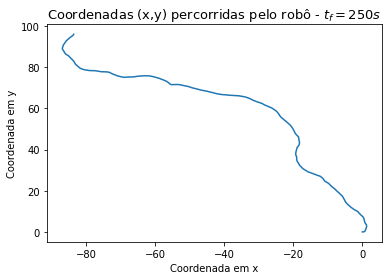

In [7]:
plt.plot(ekf_q4.X[:,0], ekf_q4.X[:,1])
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.title(r'Coordenadas (x,y) percorridas pelo robô - $t_f=250s$', fontsize=13)
plt.savefig('./images/caminhoQ4.png', dpi=600)
plt.show()

## Questão 06

In [8]:
ekf_q6 = EKF(F, G, init_state, init_sigma, Q, R, data)
for t in range(int(1375/dt)):
    ekf_q6.predict(t)
    ekf_q6.update(t)

In [9]:
pd.DataFrame(ekf_q6.Sigma, columns=['x','y',r'$\theta$',r'f_x',r'f_y'])

,x,y,$\theta$,f_x,f_y
0,0.010847,0.002988,0.000005,-0.000008,-0.000004
1,0.002988,0.000831,0.000001,-0.000002,-0.000001
2,0.000005,0.000001,0.000267,-0.000250,-0.000124
3,-0.000008,-0.000002,-0.000250,0.000500,0.000224
4,-0.000004,-0.000001,-0.000124,0.000224,0.000156


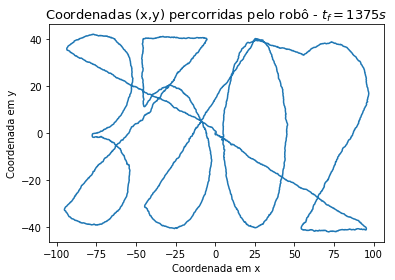

In [10]:
plt.plot(ekf_q6.X[:,0], ekf_q6.X[:,1])
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.title(r'Coordenadas (x,y) percorridas pelo robô - $t_f=1375s$', fontsize=13)
plt.savefig('./images/caminhoQ6.png',dpi=600)
plt.show()